In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class HopperDynamics(object):
    def __init__(self, dt=0.05) -> None:
        self._m  = 0.1
        self._I = np.diag([.01, .01, .01])
        self._Iinv = np.linalg.inv(self._I)
        self._g  = np.array([0.,0.,9.81])
        self._dt = dt

        def dfdt(x, u, pf):
            p, pdot = x[:6], x[6:]
            f = u
            pddot = f/self._m - self._g
            thddot = self._Iinv@ca.cross(pf, f)
            return ca.vertcat(pdot, pddot, thddot) 
        def f(x, u, p):
            return x + self._dt * self.dfdt(x, u, p)
        self.dfdt = dfdt 
        self.f = f 

hopper_model = HopperDynamics()
tf = 3
N = int(tf/hopper_model._dt)
def loss(x, u):
    J = 0.0
    xd = ca.DM([1., 1., 3.])
    for t in range(N):
        J = J + ca.sumsqr(x[:3,t]-xd) + 0.001*ca.sumsqr(x[3:,t])#+ 10*(x[1,t]-vd)**2
    J = J +  ca.sumsqr(x[:3,t]-xd) + 0.001*ca.sumsqr(x[3:,t])
    return J/float(N)

def phi(x, p):
    return x[2]-p[2]

In [3]:
opti = ca.Opti()

x    = opti.variable(12, N+1) # Decision variables for state trajetcory
lam  = opti.variable(3, N)
p    = opti.variable(3, N)
x_init  = opti.parameter(12, 1)  # initial cond Parameter (not optimized over)
# pf = opti.parameter(2,1)
opti.minimize(loss(x,lam))

for k in range(N):
  opti.subject_to(x[:,k+1]==hopper_model.f(x[:,k],lam[:,k], p[:,k]))
  opti.subject_to(phi(x[:,k], p[:,k])>=0)
  opti.subject_to(phi(x[:,k], p[:,k])*lam[:,k]<=0.01)
  opti.subject_to(lam[2,k] >= 0)
  opti.subject_to(lam[0,k]**2+lam[1,k]**2 <= (0.8*lam[2,k])**2)


opti.subject_to(opti.bounded(-1, p, 1))
opti.subject_to(x[:,0]==x_init) 



In [4]:
p_opts = {"expand": True}
s_opts = {"print_level":0, "max_iter": 1000, "acceptable_tol": 1e-3, "acceptable_obj_change_tol":1e-7, "tol":1e-8, "slack_bound_push": 0.1, "slack_bound_frac":0.5}
opti.solver('ipopt', p_opts, s_opts)

# And choose a concrete value for p
opti.set_value(x_init, [0.1,0.4, 0.5]+ [0.]*3+[0.]*6)
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.73ms (  4.31us)   3.69ms (  4.26us)       866
       nlp_g  |  12.77ms ( 14.74us)  10.66ms ( 12.31us)       866
    nlp_grad  |  45.00us ( 45.00us)  45.46us ( 45.46us)         1
  nlp_grad_f  |   5.79ms (  7.30us)   5.74ms (  7.24us)       793
  nlp_hess_l  |   5.71ms (  7.22us)   5.48ms (  6.92us)       791
   nlp_jac_g  |  18.50ms ( 23.27us)  18.59ms ( 23.39us)       795
       total  |   5.99 s (  5.99 s)   5.98 s (  5.98 s)         1


In [5]:
(x,lam, pf) = (sol.value(x).T, sol.value(lam).T, sol.value(p).T)

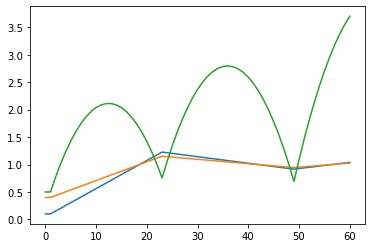

In [6]:
# plt.plot(opti.debug.value(x).T)
# plt.plot(opti.debug.value(u).T)
plt.plot(x[:,:3])
# plt.plot(x[:,0], x[:,1])
# plt.plot(t/hopper_model._dt, 2*np.sin(t * 2*2 * np.pi)+2)
# plt.plot(lam[:])

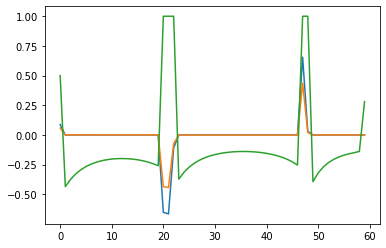

In [7]:
plt.plot(pf)